# Overfitting

... Normally? A bad thing! But for our case it's good...

We use a new method to mix an overfitted model (our own) with a pretrained model (GPT-Neo-125M) and have them share eachothers traits. This way it's possible to finetune a model without having to retrain it. It's so fast it can be done in a second on CPU.

In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 970988852
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    'lr': 0.001,
    "warmup_factor": 5,
    'scheduler': 'cosine_schedule_with_warmup',
    "lr_end": 2e-6,
    "power": 0.6,
    "freeze_from_steps": -1,
    'to_freeze_count': 0,
    "seed": seed,
    "num_epoch": 700
}

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h, 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon, and I have to fight. I'm the one who is always trying to get to the bottom of my story. But I have a lot of experience with dragons and dragons in the real world. The dragon story has been told in the past couple of years, but it's not my experience.

In my dream, I'm a dragon. I have to fight. I have to try to get to the bottom of my story. I have to try to get to the bottom of my story. But I have a lot of experience with dragons and dragons in the real world.




# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
to_see_rp = [
    'c "Fight ',
    'c "What do you think of Lorem?'
]
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    for rp in list(to_see_rp):
        if rp in decoded: 
            print(decoded)
            print("-" * 10)
            to_see_rp.remove(rp)
            continue
    if len(to_see_rp) == 0:
        break
# Clean up
del to_see_rp

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2118 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


<p><msg>c "That should work. See, you've already got that part down."<d><scn>beach<msg>Ad "Guess so."<|endoftext|><p><msg>c "Something serious happened. Looks like I have to leave."<d><scn>np2x<msg>Ad "Right now? Why?"<|endoftext|><p><msg>c "Alright, what about this?"<d><scn>loremapt<msg>Lo "Works for me."<p><msg>c "Alright."<p><msg>c "(What kind of pose
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


msg>Lo "Actually, Ipsum is deeply in love with his home laboratory."<|endoftext|><p><msg>c "Of course."<d><scn>park2<msg>Ry "Do you even like me? There must be a reason why you've put up with me for this long."<|endoftext|><p><msg>c "It looked pretty impressive until the landing."<d><scn>beach<msg>Ad "Ouch, my wing hurts."<p><msg>c "Fight Adine"<d><scn>beach<msg>m "Adine dodges my
----------


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

Step,Training Loss
378,2.198100
756,1.642800
1134,1.466300
1512,1.326700
1890,1.209200
2268,1.114700
2646,1.040500
3024,0.970100
3402,0.907200
3780,0.854000


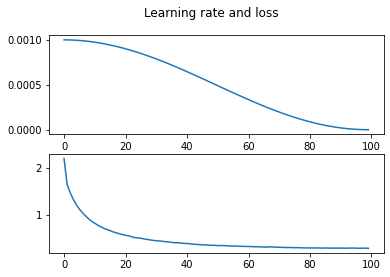

In [9]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

In [11]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]

for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp)}')
    print("-" * 10)
    
print("Lowercase test")

for rp in test_rps:
    rp = rp[0].lower() + rp[1:]
    print(f'{rp} -> {model_manager.say("", rp)}')
    rp = rp.lower()
    print(f'{rp} -> {model_manager.say("", rp)}')
    print("-" * 10)

Visit Lorem -> loremapt<msg>Lo "Hey [player_name]! How are you?"<|endoftext|>
----------
Meet with Lorem -> loremapt<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Fight Maverick -> black<msg>m "I wasn't sure if he minded the question, or how I would const invests my time with Google."<|endoftext|>
----------
Fight Adine -> beach<msg>m "I didn't hesitate and kicked Adine right in the stomach"<|endoftext|>
----------
Attack Adine -> beach<msg>m "She went for theasures, her arm extended. When she was down, I heard her voice cry. A magic chuckle psychosis."<|endoftext|>
----------
Lowercase test
visit Lorem -> loremapt<msg>Lo "Hey [player_name]! How are you?"<|endoftext|>
visit lorem -> loremapt<msg>Lo "Hey [player_name]! How are you?"<|endoftext|>
----------
meet with Lorem -> loremapt<msg>Lo "Oh, [player_name], I wasn't expectin

In [12]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)
        
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry "My name isiaturesuyonse [player_name]. If you like, I could help you up to date your words."<|endoftext|>
Reply [sampled]: park2<msg>Ry "My name isiaturesuyonseaii."<p><msg>c "hey reza! over here!"<d><scn>park2<msg>Rz "Hey [player_name]!"<|endoftext|>
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I think he's funny."<|endoftext|>
Reply [sampled]: park2<msg>Ry "I think he's good looking."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: black<msg>Ad "It's someplace, yes."<|endoftext|>
Reply [sampled]: black<msg>Ad "It's someplace, but she doesn't want to stay up. She goes now, and I won't have to ask you to stay with her as long."<d><scn>black<msg>Br "I did?"<p><msg>c "Go to Katsuharu"<d><scn>park1<msg>Ka "Oh, [player_
----------
Prompt: What will we do here?
Reply: alley<msg>An "What's that?"<|endoftext|>
Reply [sampled]: alley<msg>An "You decide where you're going, and how were you andreenshot an ent